In [31]:
import numpy as np
import pandas as pd
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
import nltk
import xgboost as xgb
from nltk import word_tokenize
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.naive_bayes import GaussianNB,MultinomialNB,BernoulliNB
from scipy.sparse import csr_matrix, hstack

# Load the Dataset

In [39]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [40]:
print("Train Dataset : ", train_df.shape)
print("Test Dataset : ", test_df.shape)

Train Dataset :  (1306122, 3)
Test Dataset :  (375806, 2)


In [41]:
train_df.head()

,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0


## Distribution of Sincere  Question

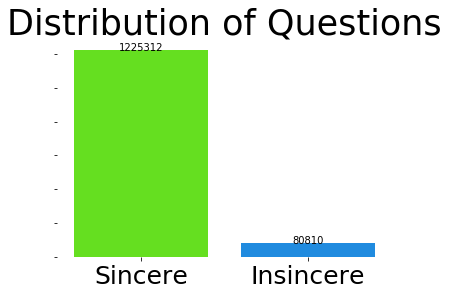

In [42]:
fig, ax = plt.subplots()
g = sns.countplot(train_df.target, palette='gist_rainbow')
g.set_xticklabels(['Sincere', 'Insincere'])
g.set_yticklabels([])

def value_bars(axs):
    def single_plot(ax):        
        for p in ax.patches:
            _x = p.get_x() + p.get_width() / 2
            _y = p.get_y() + p.get_height()
            value = '{:.0f}'.format(p.get_height())
            ax.text(_x, _y, value, ha="center") 

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            single_plot(ax)
    else:
        single_plot(axs)
value_bars(ax)

sns.despine(left=True, bottom=True)
plt.xlabel('')
plt.ylabel('')
plt.title('Distribution of Questions', fontsize=35)
plt.tick_params(axis='x', which='major', labelsize=25)
plt.show()

In [ ]:
nltk.download('stopwords')

## Some Random examples

In [44]:
import random
index = random.sample(train_df.index[train_df.target == 1].tolist(), 5)
for i in index:
    print(train_df.iloc[i, 1])

Why did the media spend months telling us Hillary Clinton was in perfect health as she stumbled around, coughed, fainted, and for months now has tried to sell the public that Trump is sick and has dementia?
As the Christian bible is based on hearsay, is it right to use it in a court of law to take the oath?
Does Indian girls like forceful sex?
How would you feel if Donald Trump got shot in the head?
How many Jews does it take to screw in a lightbulb?


## Text Processing

In [45]:
# creating a dictionary for special tokens
SPECIAL_TOKENS = {
    'quoted': 'quoted_item',
    'non-ascii': 'non_ascii_word',
    'undefined': 'something'
}


# defining a function clean to clean the data for easier modeling
def clean(text, stem_words=True):
    import re
    from string import punctuation
    from nltk.stem import SnowballStemmer
    from nltk.corpus import stopwords
    
    def pad_str(s):
        return ' '+s+' '
    
    if pd.isnull(text):
        return ''

    # stops = set(stopwords.words("english"))
    # Clean the text, with the option to stem words.
    
    # Empty question
    if type(text) != str or text == '':
        return ''

    # Clean the text
    text = re.sub("\'s", " ", text) 
    text = re.sub(" whats ", " what is ", text, flags=re.IGNORECASE)
    text = re.sub("\'ve", " have ", text)
    text = re.sub("can't", "can not", text)
    text = re.sub("n't", " not ", text)
    text = re.sub("i'm", "i am", text, flags=re.IGNORECASE)
    text = re.sub("\'re", " are ", text)
    text = re.sub("\'d", " would ", text)
    text = re.sub("\'ll", " will ", text)
    text = re.sub("e\.g\.", " eg ", text, flags=re.IGNORECASE)
    text = re.sub("b\.g\.", " bg ", text, flags=re.IGNORECASE)
    text = re.sub("(\d+)(kK)", " \g<1>000 ", text)
    text = re.sub("e-mail", " email ", text, flags=re.IGNORECASE)
    text = re.sub("(the[\s]+|The[\s]+)?U\.S\.A\.", " America ", text, flags=re.IGNORECASE)
    text = re.sub("(the[\s]+|The[\s]+)?United State(s)?", " America ", text, flags=re.IGNORECASE)
    text = re.sub("\(s\)", " ", text, flags=re.IGNORECASE)
    text = re.sub("[c-fC-F]\:\/", " disk ", text)
    
    # remove comma between numbers, i.e. 15,000 -> 15000
    text = re.sub('(?<=[0-9])\,(?=[0-9])', "", text)

    # add padding to punctuations and special chars, we still need them later
    text = re.sub('\$', " dollar ", text)
    text = re.sub('\%', " percent ", text)
    text = re.sub('\&', " and ", text)

    # replace non-ascii word with special word
    text = re.sub('[^\x00-\x7F]+', pad_str(SPECIAL_TOKENS['non-ascii']), text)
    
    # indian dollar
    text = re.sub("(?<=[0-9])rs ", " rs ", text, flags=re.IGNORECASE)
    text = re.sub(" rs(?=[0-9])", " rs ", text, flags=re.IGNORECASE)
    
    # clean text rules get from : https://www.kaggle.com/currie32/the-importance-of-cleaning-text
    text = re.sub(r" (the[\s]+|The[\s]+)?US(A)? ", " America ", text)
    text = re.sub(r" UK ", " England ", text, flags=re.IGNORECASE)
    text = re.sub(r" india ", " India ", text)
    text = re.sub(r" switzerland ", " Switzerland ", text)
    text = re.sub(r" china ", " China ", text)
    text = re.sub(r" chinese ", " Chinese ", text) 
    text = re.sub(r" imrovement ", " improvement ", text, flags=re.IGNORECASE)
    text = re.sub(r" intially ", " initially ", text, flags=re.IGNORECASE)
    text = re.sub(r" quora ", " Quora ", text, flags=re.IGNORECASE)
    text = re.sub(r" dms ", " direct messages ", text, flags=re.IGNORECASE)  
    text = re.sub(r" demonitization ", " demonetization ", text, flags=re.IGNORECASE) 
    text = re.sub(r" actived ", " active ", text, flags=re.IGNORECASE)
    text = re.sub(r" kms ", " kilometers ", text, flags=re.IGNORECASE)
    text = re.sub(r" cs ", " computer science ", text, flags=re.IGNORECASE) 
    text = re.sub(r" upvote", " up vote", text, flags=re.IGNORECASE)
    text = re.sub(r" iPhone ", " phone ", text, flags=re.IGNORECASE)
    text = re.sub(r" \0rs ", " rs ", text, flags=re.IGNORECASE)
    text = re.sub(r" calender ", " calendar ", text, flags=re.IGNORECASE)
    text = re.sub(r" ios ", " operating system ", text, flags=re.IGNORECASE)
    text = re.sub(r" gps ", " GPS ", text, flags=re.IGNORECASE)
    text = re.sub(r" gst ", " GST ", text, flags=re.IGNORECASE)
    text = re.sub(r" programing ", " programming ", text, flags=re.IGNORECASE)
    text = re.sub(r" bestfriend ", " best friend ", text, flags=re.IGNORECASE)
    text = re.sub(r" dna ", " DNA ", text, flags=re.IGNORECASE)
    text = re.sub(r" III ", " 3 ", text)
    text = re.sub(r" banglore ", " Banglore ", text, flags=re.IGNORECASE)
    text = re.sub(r" J K ", " JK ", text, flags=re.IGNORECASE)
    text = re.sub(r" J\.K\. ", " JK ", text, flags=re.IGNORECASE)
    
    # replace the float numbers with a random number, it will be parsed as number afterward, and also been replaced with
    # word "number"
    text = re.sub('[0-9]+\.[0-9]+', " 87 ", text)
    
    # Remove punctuation from text
    text = ''.join([c for c in text if c not in punctuation]).lower()

    # Return a list of words
    return text


# applying clean function on training data
train_df['question_text'] = train_df['question_text'].apply(clean)

## SVM

In [46]:
vectorizer = TfidfVectorizer(min_df=5, ngram_range=(1,3),
                        strip_accents='unicode',
                        lowercase =True, analyzer='word',
                        use_idf=True, smooth_idf=True, sublinear_tf=True, 
                        stop_words = 'english',tokenizer=word_tokenize)

In [ ]:
nltk.download('punkt')

In [47]:
vectorizer.fit(train_df.question_text.values)

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\sklearn\feature_extraction\text.py:507: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=5, ngram_range=(1, 3), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words='english', strip_accents='unicode',
                sublinear_tf=True, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=<function word_tokenize at 0x000001D41DA31730>,
                use_idf=True, vocabulary=None)

In [48]:
train_vectorized = vectorizer.transform(train_df.question_text.values)
train_vectorized

<1306122x234530 sparse matrix of type '<class 'numpy.float64'>'
	with 10058097 stored elements in Compressed Sparse Row format>

In [49]:
test_vectorized = vectorizer.transform(test_df.question_text.values)


In [50]:
X_train, X_val, y_train, y_val=train_test_split(train_vectorized,train_df.target.values,test_size=0.1,stratify =train_df.target.values)

In [51]:
from sklearn.svm import LinearSVC
svc = LinearSVC(dual=True,C=5,penalty='l2',max_iter=1000,tol=0.01)
svc.fit(X_train, y_train)

LinearSVC(C=5, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.01,
          verbose=0)

In [52]:
svc_preds=svc.predict(X_train)

In [53]:
from sklearn.metrics import f1_score, precision_score,recall_score
print("F1 Score " , f1_score(y_train,svc_preds))
print("Precision Score " ,precision_score(y_train,svc_preds))
print("Recall Score " ,recall_score(y_train,svc_preds))

F1 Score  0.8192840221885438
Precision Score  0.8810703039701252
Recall Score  0.7655955671052812


# Logistic Regression

In [37]:
from sklearn.model_selection import train_test_split
# split to train and val
train_data, val_data = train_test_split(train_df, test_size=0.2, random_state=2018)

# split training data to train and test data
train_data, test_data = train_test_split(train_df, test_size=float(1.0/8), random_state=2018)

# storing question_text and target columns in different lists
train_text = train_data['question_text']
valid_text = val_data['question_text']
test_text = test_data['question_text']
train_target = train_data['target']
valid_target = val_data['target']
test_target = test_data['target']
all_text = train_text.append(train_text)

# applying TFIDF and count vectorization to question text and target values for each training and testing data
tfidf_vectorizer = TfidfVectorizer()
tfidf_vectorizer.fit(all_text)

train_text_features_tf = tfidf_vectorizer.ktransform(train_text)
test_text_features_tf = tfidf_vectorizer.transform(test_text)

# using kfold technique for fitting and predicting using Logistic Regression
kfold = KFold(n_splits=5, shuffle=True, random_state=2018)
test_preds = 0
oof_preds = np.zeros([train_data.shape[0],])

classifier1 = LogisticRegression()
print('fitting.......')
classifier1.fit(train_text_features_tf,train_target)
pred_train=classifier1.predict_proba(train_text_features_tf)[:,1]
# training data F1 score
pred_train = np.where(pred_train > 0.25, 1, 0)
print("Training F1 score: ",f1_score(train_target, pred_train))

# training data accuracy score
print("Training Accuracy: ",accuracy_score(train_target, pred_train))

pred_test=classifier1.predict_proba(test_text_features_tf)[:,1]
pred_test = np.where(pred_test > 0.25, 1, 0)
print("Testing F1 score: ",f1_score(test_target, pred_test))

# training data accuracy score
print("Testing Accuracy: ",accuracy_score(test_target, pred_test))

fitting.......


C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Training F1 score:  0.6450546290971824
Training Accuracy:  0.9524717024717024
Testing F1 score:  0.624108995759271
Testing Accuracy:  0.9489667168914532


# Naive Bayes

In [54]:

count_vectorizer1 = CountVectorizer()
count_vectorizer1.fit(all_text)

train_text_features_cv = count_vectorizer1.transform(train_text)
test_text_features_cv = count_vectorizer1.transform(test_text)

# using kfold technique for fitting and predicting using Naive Bayes
kfold = KFold(n_splits=5, shuffle=True, random_state=2018)
test_preds = 0
oof_preds = np.zeros([train_data.shape[0],])



classifier1 = MultinomialNB()
classifier1.fit(train_text_features_cv,train_target)
pred_train=classifier1.predict_proba(train_text_features_cv)[:,1]
# training data F1 score
pred_train = np.where(pred_train > 0.25, 1, 0)
print("Training F1 score: ",f1_score(train_target, pred_train))

# training data accuracy score
print("Training Accuracy: ",accuracy_score(train_target, pred_train))

pred_test=classifier1.predict_proba(test_text_features_cv)[:,1]
pred_test = np.where(pred_test > 0.25, 1, 0)
print("Testing F1 score: ",f1_score(test_target, pred_test))

# training data accuracy score
print("Testing Accuracy: ",accuracy_score(test_target, pred_test))

Training F1 score:  0.5487336305239224
Training Accuracy:  0.9204589204589204
Testing F1 score:  0.5434520858417735
Testing Accuracy:  0.9210368355934487


# XGBoost

In [3]:
import gc
import re
from sklearn.metrics import f1_score

# XGboost related
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import xgboost as xgb
from xgboost import XGBClassifier
from scipy.sparse import csr_matrix, hstack


In [4]:
# split training data to validation
train_df, val_df = train_test_split(train_df, train_size=0.9, random_state=235)

In [5]:
print('fill missing and get the values')
# fill missing and get the values
X_train = train_df["question_text"].fillna("na_").values
X_val = val_df["question_text"].fillna("na_").values
X_test = test_df["question_text"].fillna("na_").values

y_train = train_df['target'].values
y_val = val_df['target'].values

fill missing and get the values


In [6]:
print('size of training data: ', X_train.shape)

size of training data:  (1175509,)


In [7]:
char_vector = TfidfVectorizer(
    ngram_range=(2,4),
    max_features=20000,
    stop_words='english',
    analyzer='char_wb',
    token_pattern=r'\w{1,}',
    strip_accents='unicode',
    sublinear_tf=True, 
    max_df=0.98,
    min_df=2
)


## Fit the data into TfIdfVectorizer

In [8]:
char_vector.fit(X_train[:85000])

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\sklearn\feature_extraction\text.py:520: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn("The parameter 'stop_words' will not be used"
C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\sklearn\feature_extraction\text.py:524: UserWarning: The parameter 'token_pattern' will not be used since 'analyzer' != 'word'
  warnings.warn("The parameter 'token_pattern' will not be used"


TfidfVectorizer(analyzer='char_wb', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=0.98,
                max_features=20000, min_df=2, ngram_range=(2, 4), norm='l2',
                preprocessor=None, smooth_idf=True, stop_words='english',
                strip_accents='unicode', sublinear_tf=True,
                token_pattern='\\w{1,}', tokenizer=None, use_idf=True,
                vocabulary=None)

## Tranform the Data

In [9]:
train_char_vector = char_vector.transform(X_train).tocsr()
valid_char_vector = char_vector.transform(X_val).tocsr()
test_char_vector = char_vector.transform(X_test).tocsr()

In [10]:
all_text = list(X_train) + list(X_test)

In [11]:
word_vector = TfidfVectorizer(
    ngram_range=(1,1), 
    max_features=9000,
    sublinear_tf=True, 
    strip_accents='unicode', 
    analyzer='word', 
    token_pattern="\w{1,}", 
    stop_words="english",
    max_df=0.95,
    min_df=2
)

In [12]:
word_vector.fit(all_text)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=0.95, max_features=9000,
                min_df=2, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words='english', strip_accents='unicode',
                sublinear_tf=True, token_pattern='\\w{1,}', tokenizer=None,
                use_idf=True, vocabulary=None)

In [13]:
train_word_vector = word_vector.transform(X_train).tocsr()
valid_word_vector = word_vector.transform(X_val).tocsr()
test_word_vector = word_vector.transform(X_test).tocsr()

In [14]:
del all_text
del X_train
del X_val
del X_test
gc.collect()

7

In [15]:
data = [train_df, val_df, test_df]

In [16]:
mistake_list = ['colour', 'centre', 'favourite', 'travelling', 'counselling', 'theatre', 'cancelled', 'labour', 'organisation', 'wwii', 'citicise', 'youtu ', 'youtube ', 'Qoura', 'sallary', 'Whta', 'narcisist', 'howdo', 'whatare', 'howcan', 'howmuch', 'howmany', 'whydo', 'doI', 'theBest', 'howdoes', 'mastrubation', 'mastrubate', "mastrubating", 'pennis', 'Etherium', 'narcissit', 'bigdata', '2k17', '2k18', 'qouta', 'exboyfriend', 'airhostess', 'whst', 'watsapp', 'demonitisation', 'demonitization', 'demonetisation']


In [17]:
def get_features(data):
    for dataframe in data:
        dataframe["text_size"] = dataframe["question_text"].apply(len).astype('uint16')
        dataframe["capital_size"] = dataframe["question_text"].apply(lambda x: sum(1 for c in x if c.isupper())).astype('uint16')
        dataframe["capital_rate"] = dataframe.apply(lambda x: float(x["capital_size"]) / float(x["text_size"]), axis=1).astype('float16')
        dataframe["exc_count"] = dataframe["question_text"].apply(lambda x: x.count("!")).astype('uint16')
        dataframe["quetion_count"] = dataframe["question_text"].apply(lambda x: x.count("?")).astype('uint16')
        dataframe["unq_punctuation_count"] = dataframe["question_text"].apply(lambda x: sum(x.count(p) for p in '∞θ÷α•à−β∅³π‘₹´°£€\×™√²')).astype('uint16')
        dataframe["punctuation_count"] = dataframe["question_text"].apply(lambda x: sum(x.count(p) for p in '.,;:^_`')).astype('uint16')
        dataframe["symbol_count"] = dataframe["question_text"].apply(lambda x: sum(x.count(p) for p in '*&$%')).astype('uint16')
        dataframe["words_count"] = dataframe["question_text"].apply(lambda x: len(x.split())).astype('uint16')
        dataframe["unique_words"] = dataframe["question_text"].apply(lambda x: (len(set(1 for w in x.split())))).astype('uint16')
        dataframe["unique_rate"] = dataframe["unique_words"] / dataframe["words_count"]
        dataframe["word_max_length"] = dataframe["question_text"].apply(lambda x: max([len(word) for word in x.split()]) ).astype('uint16')
        dataframe["mistake_count"] = dataframe["question_text"].apply(lambda x: sum(x.count(w) for w in mistake_list)).astype('uint16')
    return data


In [18]:
data = get_features(data)

In [19]:
feature_cols = ["text_size", "capital_size", "capital_rate", "exc_count", "quetion_count", "unq_punctuation_count", "punctuation_count", "symbol_count", "words_count", "unique_words", "unique_rate", "word_max_length", "mistake_count"]


In [21]:
X_train = csr_matrix(train_df[feature_cols].values)
X_val = csr_matrix(val_df[feature_cols].values)
X_test = csr_matrix(test_df[feature_cols].values)

In [22]:
del val_df
del train_df
del test_df

gc.collect()


175

In [23]:
input_train = hstack([X_train, train_word_vector, train_char_vector])
input_valid = hstack([X_val, valid_word_vector, valid_char_vector])
input_test = hstack([X_test, test_word_vector, test_char_vector])

#print('input_train: ', input_train)
train_word_vector = None
train_char_vector = None
valid_word_vector = None
valid_char_vector = None
test_word_vector = None
test_char_vector = None

In [24]:
def build_xgb(train_X, train_y, valid_X, valid_y=None, subsample=0.75):

    xgtrain = xgb.DMatrix(train_X, label=train_y)
    if valid_y is not None:
        xgvalid = xgb.DMatrix(valid_X, label=valid_y)
    else:
        xgvalid = None
    
    model_params = {}
    # binary 0 or 1
    model_params['objective'] = 'binary:logistic'
    # eta is the learning_rate, [default=0.3]
    model_params['eta'] = 0.3
    # depth of the tree, deeper more complex.
    model_params['max_depth'] = 6
    # 0 [default] print running messages, 1 means silent mode
    model_params['silent'] = 1
    model_params['eval_metric'] = 'auc'
    # will give up further partitioning [default=1]
    model_params['min_child_weight'] = 1
    # subsample ratio for the training instance
    model_params['subsample'] = subsample
    # subsample ratio of columns when constructing each tree
    model_params['colsample_bytree'] = subsample
    # random seed
    model_params['seed'] = 2018
    # imbalance data ratio
    #model_params['scale_pos_weight'] = 
    
    # convert params to list
    model_params = list(model_params.items())
    
    return xgtrain, xgvalid, model_params

In [25]:
def train_xgboost(xgtrain, xgvalid, model_params, num_rounds=500, patience=20):
    
    if xgvalid is not None:
        # watchlist what information should be printed. specify validation monitoring
        watchlist = [ (xgtrain, 'train'), (xgvalid, 'test') ]
        #early_stopping_rounds = stop if performance does not improve for k rounds
        model = xgb.train(model_params, xgtrain, num_rounds, watchlist, early_stopping_rounds=patience)
    else:
        model = xgb.train(model_params, xgtrain, num_rounds)
    
    return model


In [27]:
print('train the model')
xgtrain, xgvalid, model_params = build_xgb(input_train, y_train ,input_valid, y_val)
model = train_xgboost(xgtrain, xgvalid, model_params)


train the model
[0]	train-auc:0.763213	test-auc:0.758599
Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 20 rounds.
[1]	train-auc:0.774622	test-auc:0.770296
[2]	train-auc:0.819154	test-auc:0.817774
[3]	train-auc:0.850749	test-auc:0.848415
[4]	train-auc:0.858351	test-auc:0.857354
[5]	train-auc:0.868813	test-auc:0.867689
[6]	train-auc:0.876416	test-auc:0.87376
[7]	train-auc:0.879338	test-auc:0.87601
[8]	train-auc:0.883581	test-auc:0.880505
[9]	train-auc:0.890073	test-auc:0.886349
[10]	train-auc:0.894618	test-auc:0.890512
[11]	train-auc:0.898855	test-auc:0.894402
[12]	train-auc:0.901833	test-auc:0.896695
[13]	train-auc:0.904581	test-auc:0.899385
[14]	train-auc:0.908083	test-auc:0.902955
[15]	train-auc:0.910071	test-auc:0.905497
[16]	train-auc:0.91225	test-auc:0.907317
[17]	train-auc:0.913448	test-auc:0.908553
[18]	train-auc:0.915456	test-auc:0.910847
[19]	train-auc:0.917346	test-auc:0.912949
[20]	train-auc:0

[191]	train-auc:0.964086	test-auc:0.948474
[192]	train-auc:0.964146	test-auc:0.948512
[193]	train-auc:0.964247	test-auc:0.948545
[194]	train-auc:0.964324	test-auc:0.948607
[195]	train-auc:0.964385	test-auc:0.948671
[196]	train-auc:0.964458	test-auc:0.948699
[197]	train-auc:0.964528	test-auc:0.948717
[198]	train-auc:0.964589	test-auc:0.948772
[199]	train-auc:0.964675	test-auc:0.948809
[200]	train-auc:0.96475	test-auc:0.948891
[201]	train-auc:0.964819	test-auc:0.948969
[202]	train-auc:0.964888	test-auc:0.948978
[203]	train-auc:0.96494	test-auc:0.948986
[204]	train-auc:0.965019	test-auc:0.948971
[205]	train-auc:0.9651	test-auc:0.948986
[206]	train-auc:0.965138	test-auc:0.94902
[207]	train-auc:0.965201	test-auc:0.949003
[208]	train-auc:0.965271	test-auc:0.948995
[209]	train-auc:0.965306	test-auc:0.949015
[210]	train-auc:0.965376	test-auc:0.949057
[211]	train-auc:0.965423	test-auc:0.949077
[212]	train-auc:0.965475	test-auc:0.949127
[213]	train-auc:0.965544	test-auc:0.949152
[214]	train-auc:

[383]	train-auc:0.974787	test-auc:0.951883
[384]	train-auc:0.97484	test-auc:0.951902
[385]	train-auc:0.974869	test-auc:0.951928
[386]	train-auc:0.974904	test-auc:0.951986
[387]	train-auc:0.974943	test-auc:0.951956
[388]	train-auc:0.975009	test-auc:0.951978
[389]	train-auc:0.975031	test-auc:0.952013
[390]	train-auc:0.975133	test-auc:0.95217
[391]	train-auc:0.97517	test-auc:0.952171
[392]	train-auc:0.975197	test-auc:0.952203
[393]	train-auc:0.975231	test-auc:0.952229
[394]	train-auc:0.975278	test-auc:0.952215
[395]	train-auc:0.975334	test-auc:0.952232
[396]	train-auc:0.975365	test-auc:0.952237
[397]	train-auc:0.975401	test-auc:0.952227
[398]	train-auc:0.975443	test-auc:0.952234
[399]	train-auc:0.97548	test-auc:0.952243
[400]	train-auc:0.975515	test-auc:0.952248
[401]	train-auc:0.975544	test-auc:0.952241
[402]	train-auc:0.975574	test-auc:0.952263
[403]	train-auc:0.975608	test-auc:0.952276
[404]	train-auc:0.97565	test-auc:0.952266
[405]	train-auc:0.975673	test-auc:0.952254
[406]	train-auc:

In [28]:
validate_hat = np.zeros(( X_val.shape[0], 1) )
validate_hat[:,0] = model.predict(xgb.DMatrix(input_valid), ntree_limit=model.best_ntree_limit)


In [29]:
scores_list = []
for threshold in [0.2, 0.3, 0.31, 0.33, 0.4, 0.45, 0.5]:
    score = f1_score(y_val, (validate_hat > threshold).astype(int))
    scores_list.append([threshold, score])
    print('F1 score: {} for threshold: {}'.format(score, threshold))
        
    scores_list.sort(key=lambda x:x[1] , reverse=True)
    best_threshold = scores_list[0][0]
    print('best threshold to generate predictions: ', best_threshold)
    print('best score: ', scores_list[0][1])


F1 score: 0.6209603699521428 for threshold: 0.2
best threshold to generate predictions:  0.2
best score:  0.6209603699521428
F1 score: 0.6203346203346204 for threshold: 0.3
best threshold to generate predictions:  0.2
best score:  0.6209603699521428
F1 score: 0.6189679737347458 for threshold: 0.31
best threshold to generate predictions:  0.2
best score:  0.6209603699521428
F1 score: 0.6160849772382399 for threshold: 0.33
best threshold to generate predictions:  0.2
best score:  0.6209603699521428
F1 score: 0.5994295028524858 for threshold: 0.4
best threshold to generate predictions:  0.2
best score:  0.6209603699521428
F1 score: 0.5784676730276274 for threshold: 0.45
best threshold to generate predictions:  0.2
best score:  0.6209603699521428
F1 score: 0.5581947743467933 for threshold: 0.5
best threshold to generate predictions:  0.2
best score:  0.6209603699521428


# Random Forest

In [38]:
# using kfold technique for fitting and predicting using Random Forest Classifier
from sklearn.ensemble.forest import RandomForestClassifier

kfold = KFold(n_splits=5, shuffle=True, random_state=2018)
test_preds = 0
oof_preds = np.zeros([train_df.shape[0],])

classifier5 = RandomForestClassifier()
print('fitting.......')
classifier5.fit(train_text_features_tf,train_target)
pred_train=classifier5.predict_proba(train_text_features_tf)[:,1]
# training data F1 score
pred_train = np.where(pred_train > 0.25, 1, 0)
print("Training F1 score: ",f1_score(train_target, pred_train))

# training data accuracy score
print("Training Accuracy: ",accuracy_score(train_target, pred_train))

pred_test=classifier5.predict_proba(test_text_features_tf)[:,1]
pred_test = np.where(pred_test > 0.25, 1, 0)
print("Testing F1 score: ",f1_score(test_target, pred_test))

# training data accuracy score
print("Testing Accuracy: ",accuracy_score(test_target, pred_test))

fitting.......
Training F1 score:  0.9973402566617047
Training Accuracy:  0.9996701246701246
Testing F1 score:  0.5956762921872569
Testing Accuracy:  0.952231328016856
